In [1]:
import numpy as np
from numpy import random
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math, decimal
from math import exp
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier,XGBRFClassifier
from collections import Counter
seedRF =50


In [2]:
### Data manipulation and helper methods  ###
def meanStd(dataset):
    '''
    dataset_minmax(dataset)
    return a list like {min:#,max:#}
    # Find the min and std values for each column
    '''
    col = dataset.shape[1]
    meanVal, stdVal = 0,0
    stats = list()
    for i in range(col):
        val = dataset.iloc[:, i]
        meanVal = np.mean(val)
        stdVal = np.std(val)
        stats.append([meanVal,stdVal])
    return stats

def standardize_data(dataset, mean_std):
    '''
    standardize_data(dataset, mean_std)
    @mean_std: @arguent: list of min/max valuer per column {min:#,max:#}
    # Rescale dataset columns to the range 0-1
    '''
    col = dataset.shape[1]
    row = dataset.shape[0]
    for i in range(1,col):
        for n in range(row):
            dataset.iloc[n,i] -= mean_std[i][0]
            dataset.iloc[n,i] /= mean_std[i][1]
    return dataset


In [3]:
                ## uncoment to apply
####    importing original datasets and filling NaN values 
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
# ## x = pd.read_csv("x_standardized.csv", index_col = None) # to import sandardized dataset
x = train.drop('LABELS', axis=1)
# ## Correction of empty values with means by columns
xMean = x.mean()
x = x.fillna(xMean)
test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)
test_nolabels = test_nolabels.fillna(xMean)

##     Replacing columns of elevation and slope by yearly means
toposElevation = {"topo_elevation_jan",'topo_elevation_feb','topo_elevation_mar','topo_elevation_apr','topo_elevation_may','topo_elevation_jun','topo_elevation_jul','topo_elevation_aug','topo_elevation_sep','topo_elevation_oct','topo_elevation_nov','topo_elevation_dec'}
topoSlope = {'topo_slope_jan','topo_slope_feb','topo_slope_mar','topo_slope_apr','topo_slope_may','topo_slope_aug','topo_slope_jun','topo_slope_jul','topo_slope_sep','topo_slope_oct','topo_slope_nov','topo_slope_dec'}
topoElevationDF = x[toposElevation]
topoElevationMean = topoElevationDF.mean(axis=1)
x = x.drop(toposElevation,axis=1)
x['topoElevationMean'] = topoElevationMean
topoSlopeDF = x[topoSlope]
topoSlopeMean = topoSlopeDF.mean(axis=1)
x = x.drop(topoSlope, axis=1)
x['topoSlope'] = topoSlopeMean

In [4]:
     ## uncoment to apply
# #preprocessing No_label datase:
topoElevationDF = test_nolabels[toposElevation]
topoElevationMean = topoElevationDF.mean(axis=1)
topoSlopeDF = test_nolabels[topoSlope]
topoSlopeMean = topoSlopeDF.mean(axis=1)
test_nolabels = test_nolabels.drop(toposElevation, axis=1)
test_nolabels = test_nolabels.drop(topoSlope, axis=1)
test_nolabels['topoElevationMean'] = topoElevationMean
test_nolabels['topoSlope'] = topoSlopeMean
## standardizing test_nolabels
# mean_std_x_noLabel = meanStd(test_nolabels)
# test_nolabels = standardize_data(test_nolabels, mean_std_x_noLabel)

In [19]:
#### working with standardized dataSets 
# ## (All previous transformations are already done in standardized Datasets)
# train = pd.read_csv("train.csv", index_col = None)
# y = train[['LABELS']]
# x = pd.read_csv("x_standardized.csv", index_col = None)
# test_nolabels = pd.read_csv("nonLabeled_standardized.csv", index_col = None)

In [7]:
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)

In [8]:
## Data shape exploration
print("",np.shape(x_train),"  :",np.shape(x_validation) )
print("Label balance on Training set: ", "\n", y_train['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())
## reshape in column vector
y_train = (np.array(y_train).astype('int')).ravel()
y_validation = (np.array(y_validation).astype('int')).ravel()

 (49600, 195)   : (12400, 195)
Label balance on Training set:  
 1.0    32911
0.0    16689
Name: LABELS, dtype: int64
Label balance on Validation set:  
 1.0    8306
0.0    4094
Name: LABELS, dtype: int64


In [9]:
### Some helpers function
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        Return the prediction in the Kaggle format submition
        @hypotesis : column of classes 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

def predictOnSet(model, x_test):
    prediction = model.predict(x_test)
    return prediction

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)

## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
    clasifierNameExtended = clasifierName + "_info_fi.csv"     
    fi_model.to_csv(clasifierNameExtended, index = None)
    return fi_model

In [ ]:
#### Ramdomized RF  ####
# Hyperparameter grid NOTE: Grid search was transformed several time to enlage the exploration. 
# Best ramdom seach grid has been publiched in the Report
param_grid = {
    'n_estimators': np.linspace(10, 400,20).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)
# Random searsh  
y_train = np.array(y_train)rs.fit(x_train, y_train).ravel()
print(rs.best_params_, "\n")
### Working with best estimator from RandomizedSearch 
best_model = rs.best_estimator_
# Save model
joblib.dump(best_model, "rf_RandomSearch.pkl")
## Evaluating ROC Curve and extracting features priority
fi_model = evaluate_model(x_train, y_train, x_validation, y_validation, test_nolabels_prediction)
## Predicting on No_Labeled dataset and saving prediction ready to submit
# test_nolabels_prediction = predictOnSet(best_model, test_nolabels)
# savePrediction(test_nolabels_prediction, 'first_rfSearch_noLabelPrediction.csv')

In [ ]:
## XGBClassifier
estimator = XGBClassifier(use_label_encoder=False,subsample=0.9, colsample_bynode=0.2)
## Passing best estimator from Ramdomized RF to XGBoost
# NOTE: A RandomizedSearchCV was maid with a different param_grid that can be found in the report
param_grid = {
    'n_estimators': [377],
    'max_depth': [8],
    'max_leaf_nodes':[37],
    'max_features' : [0.3],
    'random_state' :[50]
}
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 4, verbose = 1, random_state=47)

rs.fit(x_train, y_train)
print(rs.best_params_, "\n")
model = rs.best_estimator_

# Save model
joblib.dump(model, "XGBCl_bestRF_Standard.pkl")

# To monitor evolution on mode.fit() and find the early soping point
eval_set = [(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)


In [10]:
model = joblib.load("XGBCl_bestRF_Standard.pkl")

[21:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features", "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-error:0.21083	validation_0-logloss:0.58360	validation_1-error:0.22508	validation_1-logloss:0.58928
[1]	validation_0-error:0.17966	validation_0-logloss:0.51223	validation_1-error:0.19782	validation_1-logloss:0.52376
[2]	validation_0-error:0.16502	validation_0-logloss:0.46416	validation_1-error:0.19185	validation_1-logloss:0.48287
[3]	validation_0-error:0.15706	validation_0-logloss:0.42547	validation_1-error:0.18637	validation_1-logloss:0.45109
[4]	validation_0-error:0.15099	validation_0-logloss:0.39994	validation_1-error:0.18419	validation_1-logloss:0.43199
[5]	val

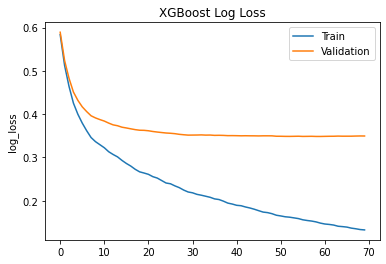

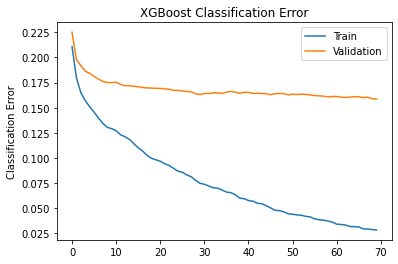

In [11]:
### ploting the model behavior on train and validation datasets over epochs (FOR XGBoost)
eval_set = [(x_train, y_train),(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('log_loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

,feature,importance
193,topoElevationMean,0.030250
194,topoSlope,0.025221
190,ERA5_temperature_2m_dec,0.024537
46,ERA5_temperature_2m_mar,0.021924
14,ERA5_temperature_2m_jan,0.019920
...,...,...
38,S2_B7_mar,0.002399
140,S1_VV_sep,0.002388
155,S2_B12_oct,0.002362
23,S2_B8_feb,0.002088


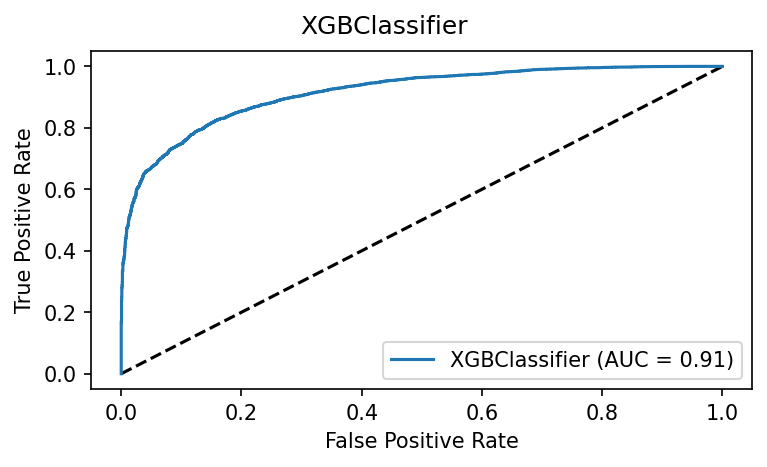

In [13]:
## ROC metric and feature priority 
evaluate_model(x_train, y_train, x_validation, y_validation, model)

In [86]:
## Prediction with XGBoost Classifier
test_nolabels_prediction = predictOnSet(model, test_nolabels)
test_nolabels_prediction = np.int8(test_nolabels_prediction)
savePrediction(test_nolabels_prediction, 'XGBCl_bestRF_Standard.csv')

[0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0
 1 1 0 1 1 1 1 1 0 1 1 1 1]


In [21]:
## Calculating F1 and ROC-AUC metrics for all produced models
modelNameList = ['rf_RandSearchStand.pkl']

for model in modelNameList:
    model = joblib.load(model)
    model.fit(x_train, y_train) 
    y_hat = model.predict(x_validation)
    f1 = f1_score(y_validation, y_hat, average ='binary',zero_division = 0)
    roc = roc_auc_score(y_validation, y_hat)
    print("quality of prediction of " + str(model) + ", f1_score:", f1, ", ROC: ", roc,"\n",)



/usr/local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Invalid parameter min_impurity_split for estimator DecisionTreeClassifier(max_depth=8, max_features=0.30000000000000004,
                       max_leaf_nodes=37). Check the list of available parameters with `estimator.get_params().keys()`.